### data1a - whole cars vs. all damaged cars

In [8]:
import urllib
from IPython.display import Image, display, clear_output
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

sns.set_style('whitegrid')

In [9]:
import os
import h5py
import numpy as np
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2, l1
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.utils.np_utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, History

In [29]:
def load_vgg16(weights_path='vgg16_weights_th_dim_ordering_th_kernels.h5'):
    model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    return model

In [18]:
f = load_vgg16()
print(f.keys())

AttributeError: 'Functional' object has no attribute 'keys'

In [7]:
def save_bottleneck_features(location):
    datagen = ImageDataGenerator(rescale=1./255)  
    
    model = load_vgg16()
    
    generator = datagen.flow_from_directory(train_data_dir,
                                            target_size=(img_width, img_height),
                                            batch_size=16, 
                                            class_mode=None, 
                                            shuffle=False) 
    
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)
    np.save(open(location+'/bottleneck_features_train.npy', 'wb'), bottleneck_features_train)
    
    # repeat with the validation data
    generator = datagen.flow_from_directory(validation_data_dir,
                                           target_size=(img_width, img_height),
                                           batch_size=16,
                                           class_mode=None,
                                           shuffle=False)
    bottleneck_features_validation = model.predict_generator(generator, nb_validation_samples)
    np.save(open(location+'/bottleneck_features_validation.npy', 'wb'), bottleneck_features_validation)

In [8]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print ("Best Model:") 
    print_best_model_results(hist)

In [2]:
def train_binary_model():

    train_data = np.load(open(location+'/bottleneck_features_train.npy', 'rb'))
    train_labels = np.array([0] * train_samples[0] + 
                            [1] * train_samples[1])

    validation_data = np.load(open(location+'/bottleneck_features_validation.npy', 'rb'))
    validation_labels = np.array([0] * validation_samples[0] + 
                                 [1] * validation_samples[1])
    
    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:])) # 512, 4, 4
    model.add(Dense(256, activation = 'relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5)) 
    model.add(Dense(1, activation = 'sigmoid')) # should activation be sigmoid for binary problem?

    model.compile(optimizers.SGD(lr=0.0001, momentum=0.9),
              loss='binary_crossentropy', metrics=['accuracy'])

    
    checkpoint = ModelCheckpoint(top_model_weights_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, save_weights_only=True, mode='auto')

    fit = model.fit(train_data, train_labels,
              epochs=nb_epoch, batch_size=16,
              validation_data=(validation_data, validation_labels),
              callbacks=[checkpoint])
    
    with open(location+'/top_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [25]:
def finetune_binary_model():
    model = load_vgg16()

    # build a classifier model to put on top of the convolutional model
    top_model = Sequential()
    top_model.add(Flatten(input_shape=model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    top_model.add(Dropout(0.5))
    top_model.add(Dense(1, activation='sigmoid'))

    top_model.load_weights(top_model_weights_path) # load weights_path

    # add the model on top of the convolutional base    
    new_model = Sequential()
    new_model.add(model)

    # CONCATENATE THE TWO MODELS
    new_model.add(top_model)

    # set the first 25 layers (up to the last conv block)
    # to non-trainable - weights will not be updated
    for layer in model.layers[:25]:
        layer.trainable=False
        
    # compile the model with a SGD/momentum optimizer 
    # and a very slow learning rate
    new_model.compile(loss='binary_crossentropy',
                 optimizer = optimizers.SGD(lr=0.00001, momentum=0.9), # reduced learning rate by 1/10
                  metrics=['accuracy'])
    
    # prepare data augmentation configuration
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator= train_datagen.flow_from_directory(train_data_dir,
                                                     target_size=(img_height, img_width),
                                                     batch_size=8,
                                                     class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                           target_size=(img_height, img_width),
                                                           batch_size=8,
                                                           class_mode='binary')
    print(len(train_generator))
    print(len(validation_generator))
    
    checkpoint = ModelCheckpoint(fine_tuned_model_path, monitor='val_accuracy', 
                                 verbose=1, save_best_only=True, 
                                 save_weights_only=False, mode='auto')
    # fine-tune the model
    fit = new_model.fit_generator(train_generator,
                              steps_per_epoch=len(train_generator)//8,
                              epochs=nb_epoch,
                              validation_data=validation_generator,
                              validation_steps=len(validation_generator)//8,
                              verbose=1,
                              callbacks=[checkpoint])
    
    with open(location+'/ft_history.txt', 'w') as f:
        json.dump(fit.history, f)
    
    return model, fit.history

In [4]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if i <0.5 else 1 for i in predictions]

    print ('')
    print (classification_report(validation_labels, pred_labels))
    print ('')
    cm = confusion_matrix(validation_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='g');

In [5]:
def view_images(img_dir, img_list):
    for img in img_list:
        clear_output()
        display(Image(img_dir+img))
        num = input("c to continue, q to quit")
        if num == 'c':
            pass
        else:
            return 'Finished for now.'

In [13]:
def print_best_model_results(model_hist):
    best_epoch = np.argmax(model_hist['val_accuracy'])
    print ('epoch:', best_epoch+1, \
    ', val_acc:', model_hist['val_accuracy'][best_epoch], \
    ', val_loss:', model_hist['val_loss'][best_epoch])

## Testing Image Generation

In [12]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest') # omitted rescaling to keep the images displayable

img = load_img('data1a/training/00-damage/0039.JPEG') # this is a PIL image 
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the 'preview/' directory
os.makedirs('data1a_preview')
i = 0
for batch in datagen.flow(x, batch_size=1,
                         save_to_dir='data1a_preview', save_prefix='damage_car',
                         save_format='jpeg'):
    i +=1
    if i > 30:
        break # otherwise the generator would loop indefinitely

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data1a_preview'

In [ ]:
view_images('data1a_preview/', os.listdir('data1a_preview/'))

## Defining input data

In [11]:
# path to the model weights file
location = 'data1a'
top_model_weights_path=location+'/top_model_weights.h5' # will be saved into when we create our model
# model_path = location + '/initial_data2_model.h5'
fine_tuned_model_path = location+'/ft_model.h5'

# dimensions of our images
img_width, img_height = 256, 256

train_data_dir = location+'/training'
validation_data_dir = location+'/validation'

train_samples = [len(os.listdir(train_data_dir+'/'+i)) for i in sorted(os.listdir(train_data_dir))]
nb_train_samples = sum(train_samples)
validation_samples = [len(os.listdir(validation_data_dir+'/'+i)) for i in sorted(os.listdir(validation_data_dir))]
nb_validation_samples = sum(validation_samples)

nb_epoch = 50

In [13]:
# do not rerun!!
save_bottleneck_features(location)

Found 1840 images belonging to 2 classes.


C:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Found 460 images belonging to 2 classes.


In [34]:
d1a_model1, d1a_history1 = train_binary_model()

Epoch 1/50
115/115 [==============================] - 4s 31ms/step - loss: 5.7377 - accuracy: 0.6092 - val_loss: 5.4562 - val_accuracy: 0.8609

Epoch 00001: val_accuracy improved from -inf to 0.86087, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 28ms/step - loss: 5.4942 - accuracy: 0.8042 - val_loss: 5.3689 - val_accuracy: 0.8761

Epoch 00002: val_accuracy improved from 0.86087 to 0.87609, saving model to data1a\top_model_weights.h5
Epoch 3/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4321 - accuracy: 0.8338 - val_loss: 5.3416 - val_accuracy: 0.8652

Epoch 00003: val_accuracy did not improve from 0.87609
Epoch 4/50
115/115 [==============================] - 3s 28ms/step - loss: 5.3424 - accuracy: 0.8498 - val_loss: 5.2766 - val_accuracy: 0.8783

Epoch 00004: val_accuracy improved from 0.87609 to 0.87826, saving model to data1a\top_model_weights.h5
Epoch 5/50
115/115 [==============================] - 3s 28m

In [35]:
d1a_model2, d1a_history2 = train_binary_model()

Epoch 1/50
115/115 [==============================] - 4s 32ms/step - loss: 5.6930 - accuracy: 0.6478 - val_loss: 5.4239 - val_accuracy: 0.8630

Epoch 00001: val_accuracy improved from -inf to 0.86304, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4584 - accuracy: 0.8194 - val_loss: 5.3495 - val_accuracy: 0.8783

Epoch 00002: val_accuracy improved from 0.86304 to 0.87826, saving model to data1a\top_model_weights.h5
Epoch 3/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3785 - accuracy: 0.8547 - val_loss: 5.3027 - val_accuracy: 0.8870

Epoch 00003: val_accuracy improved from 0.87826 to 0.88696, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3297 - accuracy: 0.8727 - val_loss: 5.2889 - val_accuracy: 0.8848

Epoch 00004: val_accuracy did not improve from 0.88696
Epoch 5/50
115/115 [==============================] - 3s 29m

In [36]:
d1a_model3, d1a_history3 = train_binary_model() 

Epoch 1/50
115/115 [==============================] - 4s 31ms/step - loss: 5.7301 - accuracy: 0.5979 - val_loss: 5.4540 - val_accuracy: 0.8522

Epoch 00001: val_accuracy improved from -inf to 0.85217, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4597 - accuracy: 0.8217 - val_loss: 5.3679 - val_accuracy: 0.8652

Epoch 00002: val_accuracy improved from 0.85217 to 0.86522, saving model to data1a\top_model_weights.h5
Epoch 3/50
115/115 [==============================] - 3s 28ms/step - loss: 5.4024 - accuracy: 0.8427 - val_loss: 5.3342 - val_accuracy: 0.8696

Epoch 00003: val_accuracy improved from 0.86522 to 0.86957, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 28ms/step - loss: 5.3256 - accuracy: 0.8772 - val_loss: 5.2853 - val_accuracy: 0.8870

Epoch 00004: val_accuracy improved from 0.86957 to 0.88696, saving model to data1a\top_model_weights.h5
Epoch 5/50



Epoch 00039: val_accuracy did not improve from 0.92391
Epoch 40/50
115/115 [==============================] - 4s 31ms/step - loss: 4.3612 - accuracy: 0.9689 - val_loss: 4.4448 - val_accuracy: 0.9196

Epoch 00040: val_accuracy did not improve from 0.92391
Epoch 41/50
115/115 [==============================] - 3s 30ms/step - loss: 4.3328 - accuracy: 0.9738 - val_loss: 4.4260 - val_accuracy: 0.9174

Epoch 00041: val_accuracy did not improve from 0.92391
Epoch 42/50
115/115 [==============================] - 3s 28ms/step - loss: 4.2953 - accuracy: 0.9825 - val_loss: 4.4072 - val_accuracy: 0.9130

Epoch 00042: val_accuracy did not improve from 0.92391
Epoch 43/50
115/115 [==============================] - 3s 28ms/step - loss: 4.2865 - accuracy: 0.9760 - val_loss: 4.3916 - val_accuracy: 0.9152

Epoch 00043: val_accuracy did not improve from 0.92391
Epoch 44/50
115/115 [==============================] - 3s 28ms/step - loss: 4.2727 - accuracy: 0.9701 - val_loss: 4.3693 - val_accuracy: 0.9174


In [37]:
d1a_model4, d1a_history4 = train_binary_model() 

Epoch 1/50
115/115 [==============================] - 4s 31ms/step - loss: 5.7131 - accuracy: 0.6625 - val_loss: 5.4295 - val_accuracy: 0.8804

Epoch 00001: val_accuracy improved from -inf to 0.88043, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4648 - accuracy: 0.8228 - val_loss: 5.3774 - val_accuracy: 0.8696

Epoch 00002: val_accuracy did not improve from 0.88043
Epoch 3/50
115/115 [==============================] - 3s 28ms/step - loss: 5.3968 - accuracy: 0.8289 - val_loss: 5.2984 - val_accuracy: 0.8913

Epoch 00003: val_accuracy improved from 0.88043 to 0.89130, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3545 - accuracy: 0.8532 - val_loss: 5.2779 - val_accuracy: 0.8913

Epoch 00004: val_accuracy did not improve from 0.89130
Epoch 5/50
115/115 [==============================] - 3s 28ms/step - loss: 5.3036 - accuracy: 0.8745 - val_lo

In [38]:
d1a_model5, d1a_history5 = train_binary_model() 

Epoch 1/50
115/115 [==============================] - 4s 31ms/step - loss: 5.7523 - accuracy: 0.5789 - val_loss: 5.4641 - val_accuracy: 0.8630

Epoch 00001: val_accuracy improved from -inf to 0.86304, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 28ms/step - loss: 5.4775 - accuracy: 0.8145 - val_loss: 5.3666 - val_accuracy: 0.8761

Epoch 00002: val_accuracy improved from 0.86304 to 0.87609, saving model to data1a\top_model_weights.h5
Epoch 3/50
115/115 [==============================] - 3s 28ms/step - loss: 5.4265 - accuracy: 0.8331 - val_loss: 5.3166 - val_accuracy: 0.8957

Epoch 00003: val_accuracy improved from 0.87609 to 0.89565, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 28ms/step - loss: 5.3546 - accuracy: 0.8551 - val_loss: 5.2710 - val_accuracy: 0.8891

Epoch 00004: val_accuracy did not improve from 0.89565
Epoch 5/50
115/115 [==============================] - 3s 28m

In [39]:
d1a_model6, d1a_history6 = train_binary_model() 

Epoch 1/50
115/115 [==============================] - 4s 32ms/step - loss: 5.7472 - accuracy: 0.6084 - val_loss: 5.4445 - val_accuracy: 0.8630

Epoch 00001: val_accuracy improved from -inf to 0.86304, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4765 - accuracy: 0.8252 - val_loss: 5.3589 - val_accuracy: 0.8717

Epoch 00002: val_accuracy improved from 0.86304 to 0.87174, saving model to data1a\top_model_weights.h5
Epoch 3/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3907 - accuracy: 0.8541 - val_loss: 5.3133 - val_accuracy: 0.8913

Epoch 00003: val_accuracy improved from 0.87174 to 0.89130, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3550 - accuracy: 0.8617 - val_loss: 5.2846 - val_accuracy: 0.8848

Epoch 00004: val_accuracy did not improve from 0.89130
Epoch 5/50
115/115 [==============================] - 3s 29m

115/115 [==============================] - 3s 29ms/step - loss: 4.3690 - accuracy: 0.9723 - val_loss: 4.4627 - val_accuracy: 0.9304

Epoch 00039: val_accuracy improved from 0.92826 to 0.93043, saving model to data1a\top_model_weights.h5
Epoch 40/50
115/115 [==============================] - 3s 29ms/step - loss: 4.3516 - accuracy: 0.9667 - val_loss: 4.4526 - val_accuracy: 0.9217

Epoch 00040: val_accuracy did not improve from 0.93043
Epoch 41/50
115/115 [==============================] - 3s 29ms/step - loss: 4.3402 - accuracy: 0.9695 - val_loss: 4.4280 - val_accuracy: 0.9174

Epoch 00041: val_accuracy did not improve from 0.93043
Epoch 42/50
115/115 [==============================] - 3s 29ms/step - loss: 4.3069 - accuracy: 0.9726 - val_loss: 4.4208 - val_accuracy: 0.9152

Epoch 00042: val_accuracy did not improve from 0.93043
Epoch 43/50
115/115 [==============================] - 3s 29ms/step - loss: 4.2844 - accuracy: 0.9747 - val_loss: 4.3913 - val_accuracy: 0.9174

Epoch 00043: val_a

In [40]:
d1a_model7, d1a_history7 = train_binary_model()

Epoch 1/50
115/115 [==============================] - 4s 31ms/step - loss: 5.7538 - accuracy: 0.6253 - val_loss: 5.4931 - val_accuracy: 0.8152

Epoch 00001: val_accuracy improved from -inf to 0.81522, saving model to data1a\top_model_weights.h5
Epoch 2/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4927 - accuracy: 0.8097 - val_loss: 5.4801 - val_accuracy: 0.8000

Epoch 00002: val_accuracy did not improve from 0.81522
Epoch 3/50
115/115 [==============================] - 3s 29ms/step - loss: 5.4073 - accuracy: 0.8390 - val_loss: 5.3242 - val_accuracy: 0.8717

Epoch 00003: val_accuracy improved from 0.81522 to 0.87174, saving model to data1a\top_model_weights.h5
Epoch 4/50
115/115 [==============================] - 3s 29ms/step - loss: 5.3511 - accuracy: 0.8524 - val_loss: 5.2881 - val_accuracy: 0.8783

Epoch 00004: val_accuracy improved from 0.87174 to 0.87826, saving model to data1a\top_model_weights.h5
Epoch 5/50
115/115 [==============================] - 3s 29m


Epoch 00039: val_accuracy did not improve from 0.92391
Epoch 40/50
115/115 [==============================] - 4s 31ms/step - loss: 4.3534 - accuracy: 0.9684 - val_loss: 4.4437 - val_accuracy: 0.9239

Epoch 00040: val_accuracy did not improve from 0.92391
Epoch 41/50
115/115 [==============================] - 4s 32ms/step - loss: 4.3283 - accuracy: 0.9810 - val_loss: 4.4249 - val_accuracy: 0.9217

Epoch 00041: val_accuracy did not improve from 0.92391
Epoch 42/50
115/115 [==============================] - 3s 30ms/step - loss: 4.3178 - accuracy: 0.9701 - val_loss: 4.4051 - val_accuracy: 0.9217

Epoch 00042: val_accuracy did not improve from 0.92391
Epoch 43/50
115/115 [==============================] - 4s 32ms/step - loss: 4.2932 - accuracy: 0.9716 - val_loss: 4.3853 - val_accuracy: 0.9196

Epoch 00043: val_accuracy did not improve from 0.92391
Epoch 44/50
115/115 [==============================] - 4s 31ms/step - loss: 4.2694 - accuracy: 0.9802 - val_loss: 4.3707 - val_accuracy: 0.9196


Best Model:
epoch: 44 , val_acc: 0.9217391014099121 , val_loss: 4.363719940185547


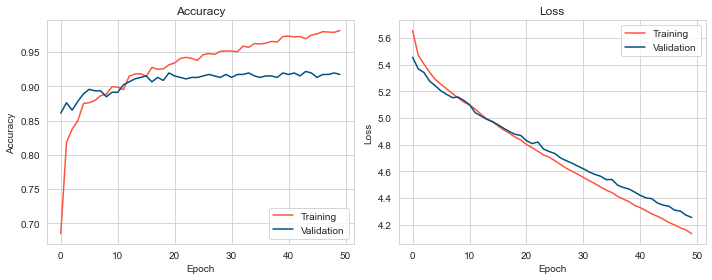

In [41]:
plot_metrics(d1a_history1) # rmsprop, sigmoid, no regularization

Best Model:
epoch: 31 , val_acc: 0.9239130616188049 , val_loss: 4.627809047698975


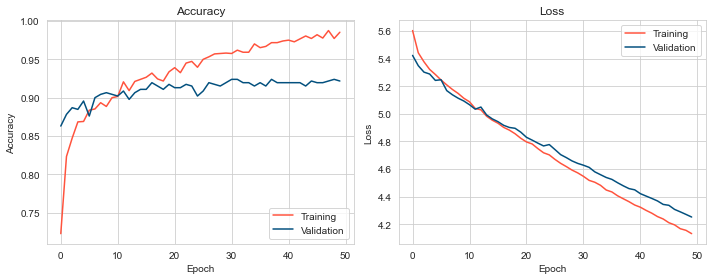

In [42]:
plot_metrics(d1a_history2) # rmsprop, sigmoid, with l2 regularization (0.01)

Best Model:
epoch: 22 , val_acc: 0.9239130616188049 , val_loss: 4.813095569610596


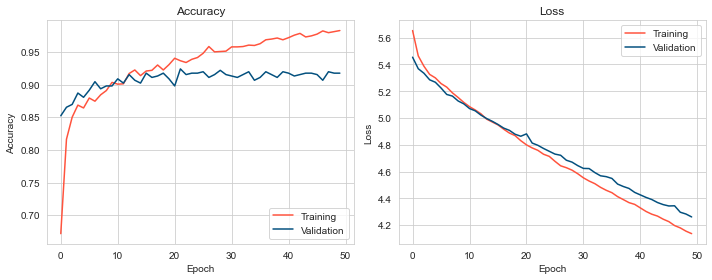

In [43]:
plot_metrics(d1a_history3) # rmsprop, sigmoid, with double dense and dropout layers

Best Model:
epoch: 24 , val_acc: 0.926086962223053 , val_loss: 4.782263278961182


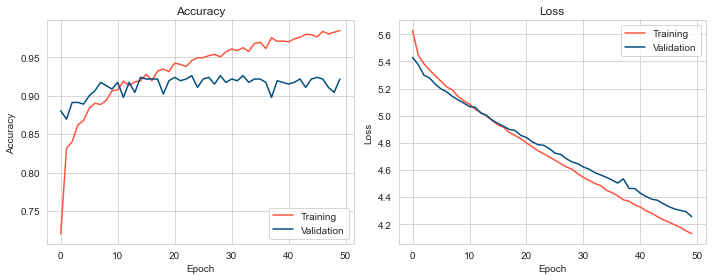

In [44]:
plot_metrics(d1a_history4) # rmsprop, sigmoid, with aggresive dropout (.75)

Best Model:
epoch: 28 , val_acc: 0.928260862827301 , val_loss: 4.684326648712158


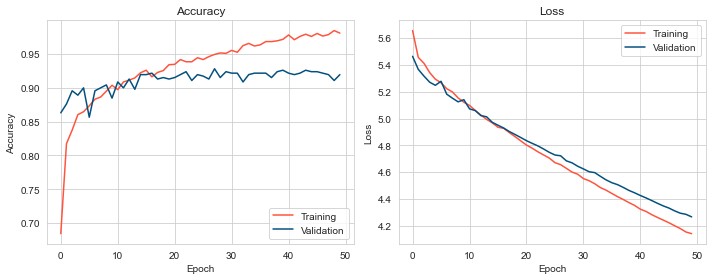

In [45]:
plot_metrics(d1a_history5) # rmsprop, sigmoid, with l2 = 0.001

Best Model:
epoch: 39 , val_acc: 0.9304347634315491 , val_loss: 4.462749481201172


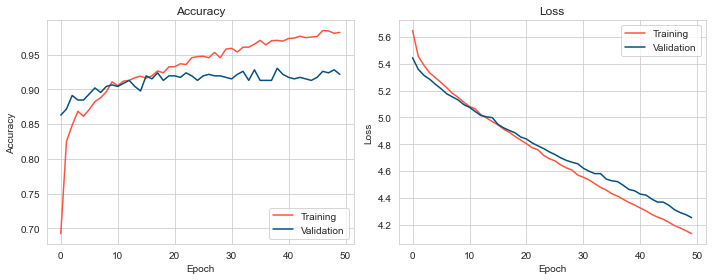

In [46]:
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 39 , val_acc: 0.9304347634315491 , val_loss: 4.462749481201172


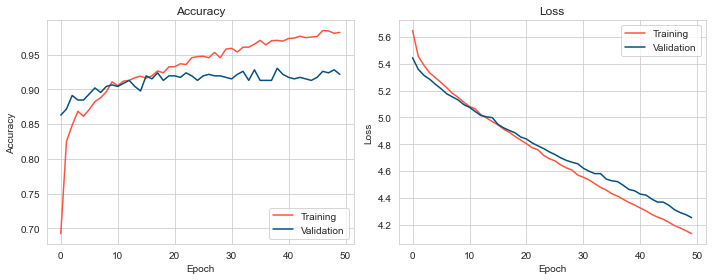

In [47]:
# WINNER
plot_metrics(d1a_history6) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

Best Model:
epoch: 50 , val_acc: 0.926086962223053 , val_loss: 4.257760047912598


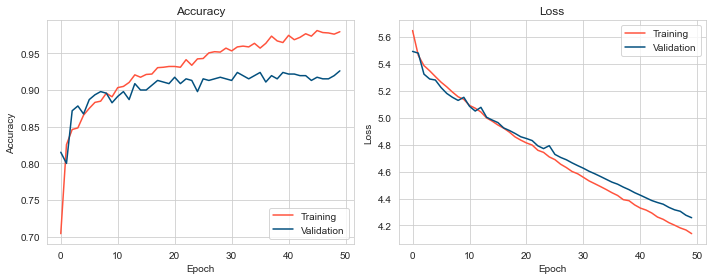

In [48]:
plot_metrics(d1a_history7) # sgd with lr = 0.001 and decay 1e-6, sigmoid, with l2 = 0.001

## Fine Tuning

In [ ]:
ft_model, ft_history = finetune_binary_model()

Found 1840 images belonging to 2 classes.
Found 460 images belonging to 2 classes.
230
58
Epoch 1/50
28/28 [==============================] - 47s 1s/step - loss: 4.4951 - accuracy: 0.7929 - val_loss: 4.3780 - val_accuracy: 0.8214

Epoch 00001: val_accuracy improved from -inf to 0.82143, saving model to data1a\ft_model.h5
Epoch 2/50
28/28 [==============================] - 30s 1s/step - loss: 4.5767 - accuracy: 0.8141 - val_loss: 4.4026 - val_accuracy: 0.8571

Epoch 00002: val_accuracy improved from 0.82143 to 0.85714, saving model to data1a\ft_model.h5
Epoch 3/50
28/28 [==============================] - 30s 1s/step - loss: 4.5708 - accuracy: 0.7128 - val_loss: 4.4761 - val_accuracy: 0.8036

Epoch 00003: val_accuracy did not improve from 0.85714
Epoch 4/50
28/28 [==============================] - 30s 1s/step - loss: 4.4517 - accuracy: 0.7966 - val_loss: 4.2903 - val_accuracy: 0.8750

Epoch 00004: val_accuracy improved from 0.85714 to 0.87500, saving model to data1a\ft_model.h5
Epoch 5/5

Best Model:
epoch: 1 , val_acc: 0.0 , val_loss: 7.083938121795654


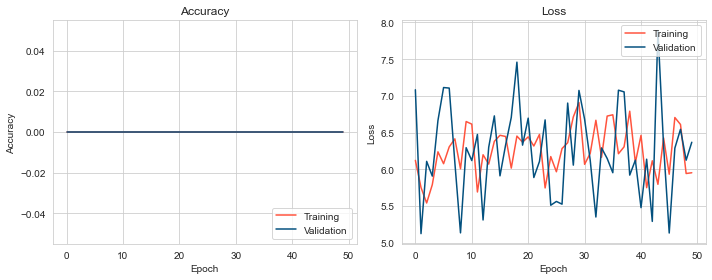

In [28]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

## Load Model Point

In [23]:
ft_model = load_model(location+'/ft_model.h5')

In [13]:
ft_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0     

In [16]:
with open('data1a/top_history.txt') as f:    
    top_history = json.load(f)

In [17]:
with open('data1a/ft_history.txt') as f:    
    ft_history = json.load(f)

In [18]:
def plot_metrics(hist, stop=50):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
                            
    axes = axes.flatten()

    axes[0].plot(range(stop), hist['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Accuracy')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist['loss'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist['val_loss'], label='Validation', color='#03507E')
    axes[1].set_title('Loss')
    axes[1].set_ylabel('Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')
                             
    plt.tight_layout();
    
    print ("Best Model:") 
    print_best_model_results(hist)

In [19]:
def plot_acc_metrics(hist1, hist2, stop=50):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4.25,6))
                            
    axes = axes.flatten()
    
    axes[0].plot(range(stop), hist1['accuracy'], label='Training', color='#FF533D')
    axes[0].plot(range(stop), hist1['val_accuracy'], label='Validation', color='#03507E')
    axes[0].set_title('Training')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='lower right')
                             
    axes[1].plot(range(stop), hist2['accuracy'], label='Training', color='#FF533D')
    axes[1].plot(range(stop), hist2['val_accuracy'], label='Validation', color='#03507E')
    axes[1].set_title('Fine-tuning')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='lower right')
                             
    plt.tight_layout();

In [63]:
def evaluate_binary_model(model, directory, labels):
    datagen = ImageDataGenerator(rescale=1./255)  

    generator = datagen.flow_from_directory(directory,
                                target_size=(img_height, img_width),
                                batch_size=8,
                                class_mode='binary', # categorical for multiclass
                                shuffle=False)
    
    predictions = model.predict_generator(generator, len(labels))
    
    # use for multiclass
    # pred_labels = np.argmax(predictions, axis=1)
    
    pred_labels = [0 if (i <0.5).all() else 1 for i in predictions]

    print ('')
    print (classification_report(validation_labels, pred_labels))
    print ('')
    cm = confusion_matrix(validation_labels, pred_labels)
    return cm 

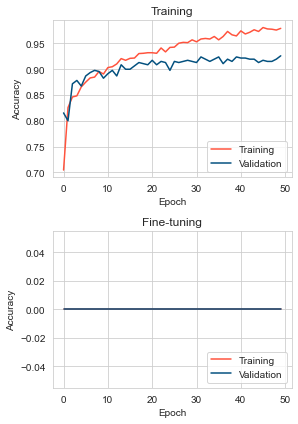

In [21]:
plot_acc_metrics(top_history, ft_history)

Best Model:
epoch: 1 , val_acc: 0.0 , val_loss: 7.083938121795654


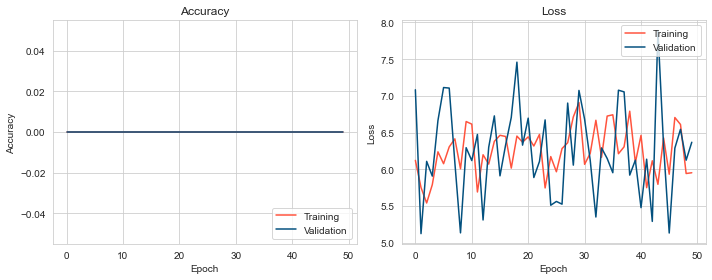

In [22]:
# WINNER
plot_metrics(ft_history) # sgd with lr = 0.0001, sigmoid, with l2 = 0.001

In [23]:
validation_labels = np.array([0] * validation_samples[0] + 
                             [1] * validation_samples[1])

In [64]:
cm = evaluate_binary_model(ft_model, validation_data_dir, validation_labels)

Found 460 images belonging to 2 classes.


C:\anaconda\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       230
           1       0.50      1.00      0.67       230

    accuracy                           0.50       460
   macro avg       0.25      0.50      0.33       460
weighted avg       0.25      0.50      0.33       460




C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
heatmap_labels = ['Damaged', 'Whole']

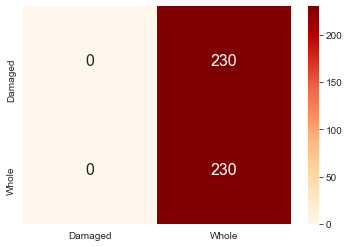

In [66]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='OrRd', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

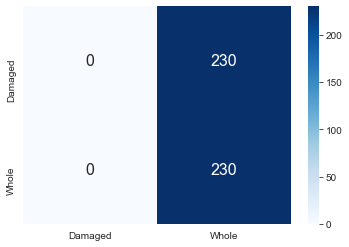

In [67]:
sns.heatmap(cm, annot=True, annot_kws={"size": 16}, 
            fmt='g', cmap='Blues', xticklabels=heatmap_labels, yticklabels=heatmap_labels);

## Making Live Predictions

In [48]:
def car_categories_gate(image_path, model):
    urllib.request.urlretrieve(image_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(256, 256)) # this is a PIL image 
    x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
    x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
    pred = model.predict(x)
    print ("Validating that damage exists...")
    print (pred)
    if (pred[0][0] <=.5).any():

        print ("Validation complete - proceed to location and severity determination")
    else:
        print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        print ("Hint: Try zooming in/out, using a different angle or different lighting")

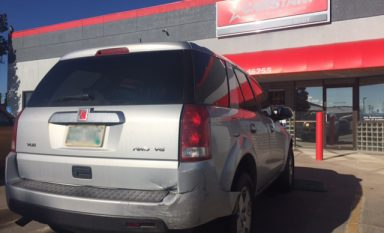

In [46]:
Image('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg')

In [49]:
car_categories_gate('https://www.nerdwallet.com/blog/wp-content/uploads/2015/12/exterior-car-damage-384x233.jpg', ft_model)

Validating that damage exists...
[[[[0.         0.         0.         ... 0.         0.4850089
    0.        ]
   [0.         0.         0.         ... 0.         0.8373869
    0.        ]
   [0.00419533 0.         0.         ... 0.         1.0964663
    0.        ]
   ...
   [0.         0.         0.         ... 0.         0.09521067
    0.        ]
   [0.7798882  0.         0.         ... 0.         0.14615741
    0.        ]
   [0.6093986  0.         0.         ... 0.         0.65957737
    0.        ]]

  [[0.         0.         0.         ... 0.         0.07181758
    0.        ]
   [0.29819715 0.         0.         ... 0.         0.6243127
    0.        ]
   [1.0997584  0.         0.         ... 0.2447578  0.9728447
    0.        ]
   ...
   [0.0876319  0.         0.         ... 0.         0.47409877
    0.        ]
   [0.28085902 0.         0.         ... 0.         0.6834772
    0.        ]
   [0.16159797 0.         0.         ... 0.         0.8362948
    0.        ]]

  [[0.19

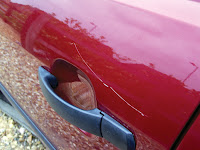

In [50]:
Image('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg')

In [51]:
car_categories_gate('http://1.bp.blogspot.com/-ToQS-qIxYbo/UDNuV5OcVQI/AAAAAAAABdo/tjeQywWiOo0/s200/Key+scratch.jpg', ft_model)

Validating that damage exists...
[[[[0.0000000e+00 0.0000000e+00 3.7677717e-01 ... 5.4114985e-01
    1.3958313e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 5.8338165e-02 ... 3.4305739e-01
    1.3737299e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    1.2109315e+00 0.0000000e+00]
   ...
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    1.4503467e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
    1.4760695e+00 0.0000000e+00]
   [1.3927788e-02 0.0000000e+00 1.1809468e-03 ... 0.0000000e+00
    1.4254372e+00 0.0000000e+00]]

  [[0.0000000e+00 0.0000000e+00 2.0556444e-01 ... 7.8221124e-01
    1.2654332e+00 0.0000000e+00]
   [0.0000000e+00 0.0000000e+00 5.1860839e-02 ... 9.5221168e-01
    1.5310452e+00 0.0000000e+00]
   [4.9922422e-01 0.0000000e+00 1.9429347e-01 ... 8.5467672e-01
    1.7987559e+00 0.0000000e+00]
   ...
   [2.2270820e-01 0.0000000e+00 0.0000000e+00 ... 6.0994275e-02
    1.5804046e

In [52]:
Image('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg')

HTTPError: HTTP Error 404: Not Found

In [ ]:
car_categories_gate('https://www.carfax.com/media/zoo/images/rsz_frame-damage_85730e0a843d155e25e4b0f0e100bf65.jpg', ft_model)

## Looking at edge cases

In [57]:
def get_edge_cases(model, directory, exp_result):
    img_list = os.listdir(directory)
    edge_list = []
    for name in img_list:
        img = load_img(directory+name, target_size=(256, 256)) # this is a PIL image 
        x = img_to_array(img) # this is a Numpy array with shape (3, 256, 256)
        x = x.reshape((1,) + x.shape)/255 # this is a Numpy array with shape (1, 3, 256, 256)
        pred_prob = model.predict(x)
        if (pred_prob <=0.5).any():
            pred = 0
        else:
            pred = 1
        if pred != exp_result:
            edge_list.append(name)
    return edge_list

In [54]:
evaluate_binary_model(ft_model, validation_data_dir, validation_labels)
# TP = 221, TN = 194, FP = 36, FN = 9
# 9 were predicted to be damaged but were actually whole
# 36 were predicted to be whole but were actually damaged

Found 460 images belonging to 2 classes.


C:\anaconda\lib\site-packages\keras\engine\training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '



              precision    recall  f1-score   support

           0       0.50      1.00      0.67       230
           1       0.00      0.00      0.00       230

    accuracy                           0.50       460
   macro avg       0.25      0.50      0.33       460
weighted avg       0.25      0.50      0.33       460




C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[230,   0],
       [230,   0]], dtype=int64)

In [58]:
fp = get_edge_cases(ft_model, 'data1a/validation/00-damage/', 0)

In [59]:
len(fp)

0

In [60]:
view_images('data1a/validation/00-damage/', fp)  # damaged, identifed as whole

In [61]:
fn = get_edge_cases(ft_model, 'data1a/validation/01-whole/', 1)

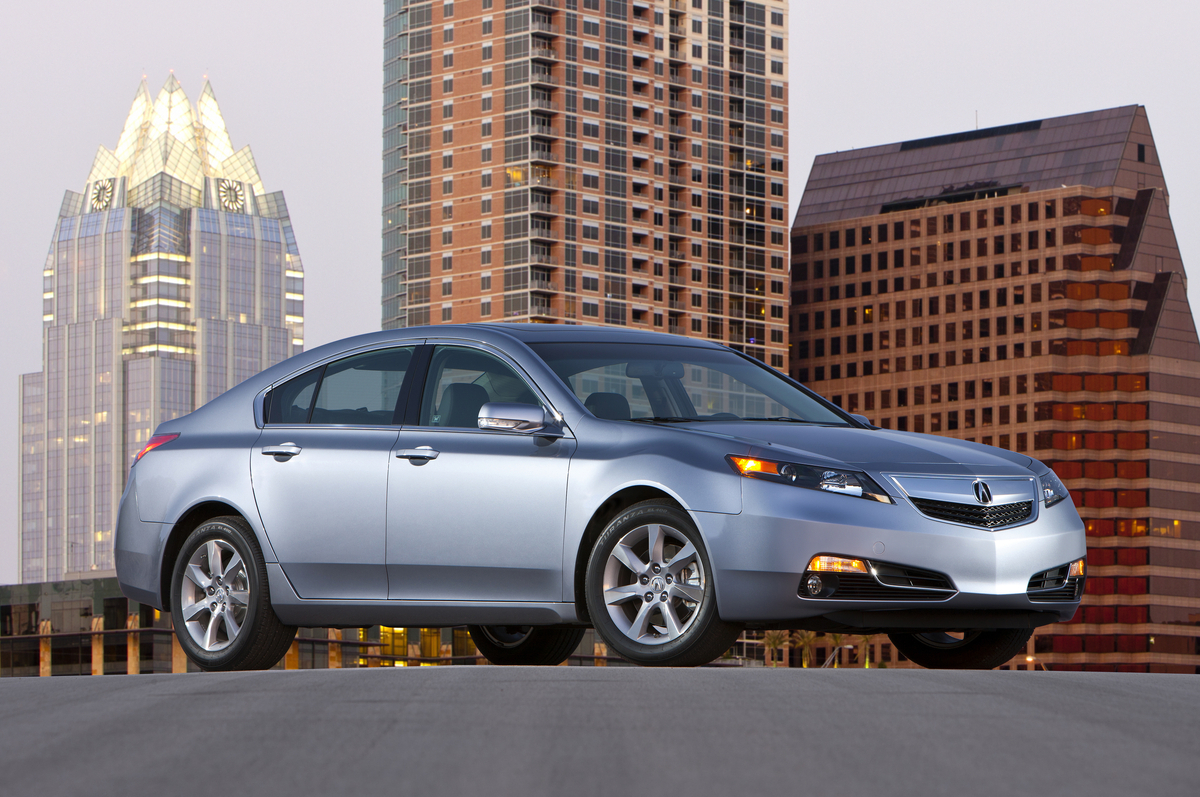

c to continue, q to quitq


'Finished for now.'

In [62]:
view_images('data1a/validation/01-whole/', fn) #whole, identified as damaged